In [1]:
import geopandas as gpd
import pandas as pd

dfde = gpd.read_parquet('../data/processed_datasets/simplified_refined_DFDE_1984_2021_EPSG2154_FR.parquet') #ok 
hm = gpd.read_parquet('../data/processed_datasets/simplified_health-monitoring_2007-2023_EPSG2154_FR.parquet') #ok 
nfi = gpd.read_parquet('../data/processed_datasets/simplified_NFI_2003-2021_EPSG2154_FR.parquet') #ok 
senfseidl = gpd.read_parquet("../data/processed_datasets/simplified_SenfSeidl_joined_EPSG2154_FR.parquet") #ok 
bdiff = gpd.read_parquet('../data/processed_datasets/simplified_bdiff_2012_2022_FR_EPSG2154.parquet') #ok 
cdi = gpd.read_parquet('../data/processed_datasets/simplified_CDI_2012_2023_EPSG2154_FR.parquet') #ajouter tree-specie
forms = gpd.read_parquet('../data/processed_datasets/simplified_FORMS_clearcut_2017_2020_EPSG2154.parquet') #ok


#preprocessing bdiff:
bdiff['class'] = 'Fire'
bdiff = bdiff[ bdiff.forest_area_m2 > 5000 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


bdiff[['start_date', 'end_date']] = bdiff.apply(to_datetime_safe, axis=1, result_type='expand')

#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

#autoreload 
from attribution2 import Attribution
from constants import DCLASS_SCORE

temporal_buffer = 2 

#subset of datasets
ddataset = {'dfde': dfde, 'hm': hm, 'nfi': nfi, 'senfseidl': senfseidl, 'bdiff': bdiff, 'cdi':cdi, 'forms':forms}
dtypes = {'dfde': 'polygon', 'hm': 'point', 'nfi': 'point', 'senfseidl': 'point', 'bdiff': 'polygon', 'cdi':'polygon', 'forms':'point'}

ddataset_profile = {
    'dfde': {
        'spatial': ('offset_gaussian', {'offset': 150, 'decrease': 5000}), #offset srt( min(area) / pi), k sqrt(median(area) / pi)
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'hm': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 100}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'nfi': {
        'spatial': ('offset_gaussian', {'offset': 600, 'decrease': 25}),
        'temporal': ('step', {'start': 0, 'end': 5 * 365})
    },
    'bdiff': {
        'spatial': ('weighting_function', {'x0': 500, 'k': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 30})
    },
    'senfseidl': {
        'spatial': ('offset_gaussian', {'offset': 30, 'decrease': 5 * 30}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 1.5 * 365})
    },
    'forms': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 5*10}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'reference': {
        'spatial': ('offset_gaussian', {'offset': 0, 'decrease': 3 * 50}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'cdi': {
        'spatial': ('offset_gaussian', {'offset': 5000, 'decrease': 500}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 365})
    },
}

#visible disturbances
ddisturbance_profile = {
    'fire': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'storm': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1.5 * 365})
    },
    'biotic-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 1000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 365})
    },
    'drought-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 2*365})
    },
    'biotic-mortality': {
        'spatial': ('gaussian', {'mean': 0, 'std': 250}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'anthropogenic': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1 * 365})
    }
}

doa = {'dfde': 1.0, 'hm': 1.0, 'nfi': 1.0, 'senfseidl': .75, 'bdiff': 1.0, 'cdi':.75, 'forms':0.75}
dsbuffer = {'dfde': None, 'hm': 5000, 'nfi': 7000, 'senfseidl': 100, 'bdiff': None, 'cdi':100, 'forms':100}

attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, 
                          temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, 
                          dclass_score=DCLASS_SCORE, granularity=5, 
                          ddataset_profile=ddataset_profile, ddisturbance_profile=ddisturbance_profile, 
                          start_year=2017)

dataset dfde is of spatial entity type
-> 95% of the areas are below : 4391.95 km2, median : 71.66 km2
dataset bdiff is of spatial entity type
-> 95% of the areas are below : 127.49 km2, median : 27.37 km2
dataset cdi is of spatial entity type
-> 95% of the areas are below : 174.72 km2, median : 25.00 km2


# Build the communities

In [2]:
from utils import is_temporally_similar
import networkx as nx
import numpy as np
from tqdm import tqdm 

def build_graph(dataset_loc, dataset_glob,  sindex, spatial_threshold, temporal_threshold, attribution, G=None):
    
    if G is None:
        G = nx.Graph()
        # Construct the similarity matrix using spatial index
    for event1 in tqdm(dataset_loc.itertuples(index=True)):
        i = event1.Index
        # Find nearby events within spatial threshold
        possible_matches_index = list(sindex.intersection(event1.geometry.buffer(spatial_threshold).bounds))
        possible_matches = dataset_glob.iloc[possible_matches_index]

        for event2 in possible_matches.itertuples(index=True):
            j = event2.Index
            if i != j and is_temporally_similar(event1, event2, temporal_threshold):
                ds = event1.geometry.centroid.distance(event2.geometry.centroid)
                dt = abs(event1.centroid_date - event2.centroid_date).days 
                weight = np.mean([attribution.final_weighting_dict[event1.dataset][event1._3]['spatial'](ds), attribution.final_weighting_dict[event2.dataset][event2._3]['spatial'](ds), attribution.final_weighting_dict[event1.dataset][event1._3]['temporal'](dt), attribution.final_weighting_dict[event2.dataset][event2._3]['temporal'](dt)])
                G.add_edge(i, j, weight = weight)
    
    return G 

In [4]:
from utils import is_temporally_similar, get_temporal_range
from shapely import box
from shapely.geometry import shape 
import numpy as np
bounds_4326 = (4.75,47.10,6.82,48.51)
pol_4326 = box(*bounds_4326)
import rasterio 
from rasterio.warp import transform_geom
pol_2154 = shape(transform_geom('epsg:4326', attribution.dataset.crs, pol_4326))

_dataset = attribution.dataset.clip(pol_2154)
n = _dataset.shape[0] / attribution.dataset.shape[0] * 100
_spatial_entity_dataset = attribution.spatial_entity_dataset.clip(pol_2154)
m = _spatial_entity_dataset.shape[0] / attribution.spatial_entity_dataset.shape[0] * 100
temporal_threshold = 180 * 2
spatial_threshold = 600
resolution = 100
print(n, m)
import os 
from tqdm import tqdm 
import networkx as nx 
b = "_".join([str(x) for x in bounds_4326])

temporal_threshold_ = temporal_threshold 
spatial_threshold_ = spatial_threshold
if os.path.isfile(f"../data/results/clusters/communities_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.parquet"):
    all_clusters_gdf = gpd.read_parquet(f"../data/results/clusters/communities_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.parquet")
    c = all_clusters_gdf.shape[0] / (_spatial_entity_dataset.shape[0] + _dataset.shape[0] )
else : 
    dataset = _dataset[['geometry', 'dataset', 'class', 'centroid_date']]
    spatial_entity_dataset = _spatial_entity_dataset[['geometry', 'centroid_date']]
    sindex = dataset.sindex
    spatial_entity_sindex = spatial_entity_dataset.sindex

    if os.path.isfile(f"../data/results/graph/graph_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.gml"):
        G = nx.read_gml(f"../data/results/graph/graph_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.gml")

    else: 
        # Assuming gdf is your GeoDataFrame
        print('Building graph...')
        G = nx.Graph()
        dataset_loc = dataset
        #while graph not connected build graph by doubling thresholds
        N = 3
        i = 0
        while (len(G) == 0 or not nx.is_connected(G)) and (i < N or len(dataset_loc) > 0):
            G = build_graph(dataset_loc, dataset, sindex, spatial_threshold, temporal_threshold, attribution, G=G)
            spatial_threshold *= 2
            temporal_threshold *= 2
            print(f'graph not connected, new thresholds : {spatial_threshold}m, {temporal_threshold}d')
            #set d as the dataset with the events not in the graph
            dataset_loc = dataset[~dataset.index.isin(G.nodes())]
            i += 1
        
        nx.write_gml(G, f"../data/results/graph/graph_{attribution.granularity}_{spatial_threshold_}_{temporal_threshold_}_{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.gml")

    # islands = list(nx.connected_components(G))
    communities = nx.community.louvain_communities(G, seed=0, resolution=resolution)

    # Create a list to store the sub-GeoDataFrames
    island_gdfs = []

    print('Building islands...')
    # Iterate over each island and create a sub-GeoDataFrame
    for island in tqdm(communities):
        # Select rows from the original GeoDataFrame that correspond to the current island
        island_gdf = attribution.dataset.iloc[list(island)]
        
        # Append this sub-GeoDataFrame to the list
        island_gdfs.append(island_gdf)

    for i, island_gdf in tqdm(enumerate(island_gdfs)):
        # Calculate the envelope (bounding box) of the cluster
        envelope = island_gdf.unary_union.envelope

        # Calculate the temporal range of the cluster
        cluster_start, cluster_end = get_temporal_range(island_gdf)

        # Find potential matches using spatial index
        possible_matches_index = list(spatial_entity_sindex.intersection(envelope.bounds))
        possible_matches = spatial_entity_dataset.iloc[possible_matches_index]

        if len(possible_matches_index) > 0 :
            break
        # Initialize an empty list to store events to be added
        events_to_add = []

        # Iterate through each potential match
        for event in possible_matches.itertuples(index=True):
            # Check spatial intersection
            spatial_condition = envelope.intersects(event.geometry)
            # Check temporal intersection
            event_start = event.start_date  # Replace with your actual column name
            event_end = event.end_date
            temporal_condition = ((event_start <= cluster_end + temporal_threshold) and (event_end >= cluster_end - temporal_threshold)) or ((event_start <= cluster_start + temporal_threshold) and (event_end >= cluster_start - temporal_threshold)) 

            # If both conditions are met, add the event to the list
            if spatial_condition and temporal_condition:
                events_to_add.append(event.Index)

        # Add the events to the cluster GeoDataFrame
        if len(events_to_add) > 0:
            additional_events = attribution.spatial_entity_dataset.loc[events_to_add]
            island_gdfs[i] = gpd.GeoDataFrame(pd.concat([island_gdf, additional_events]), geometry='geometry', crs=island_gdf.crs)
    
    # Initialize an empty list to store the modified cluster GeoDataFrames          
    modified_gdfs = []

    # Add a 'cluster' column and concatenate
    for i, island_gdf in tqdm(enumerate(island_gdfs)):
        island_gdf['cluster'] = i  # Add a 'cluster' column with the cluster index
        modified_gdfs.append(island_gdf)


    # Ensure the GeoDataFrame has the correct geometry set
    all_clusters_gdf = gpd.GeoDataFrame(pd.concat(modified_gdfs), geometry='geometry').drop(columns=['year'])

    # Save to GeoParquet
    c = all_clusters_gdf.shape[0] / (_spatial_entity_dataset.shape[0] + _dataset.shape[0] )
    all_clusters_gdf.to_parquet(f"../data/results/clusters/communities_r{resolution}_g{attribution.granularity}_{spatial_threshold}m_{temporal_threshold}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.parquet")

print(f'conversion rate : {c :.2%}')
        

8.353069463256475 2.4287716020551144
conversion rate : 99.84%


Text(0.5, 1.0, 'conversion rate : 99.84%, tt : 5760 d, st : 9600 m')

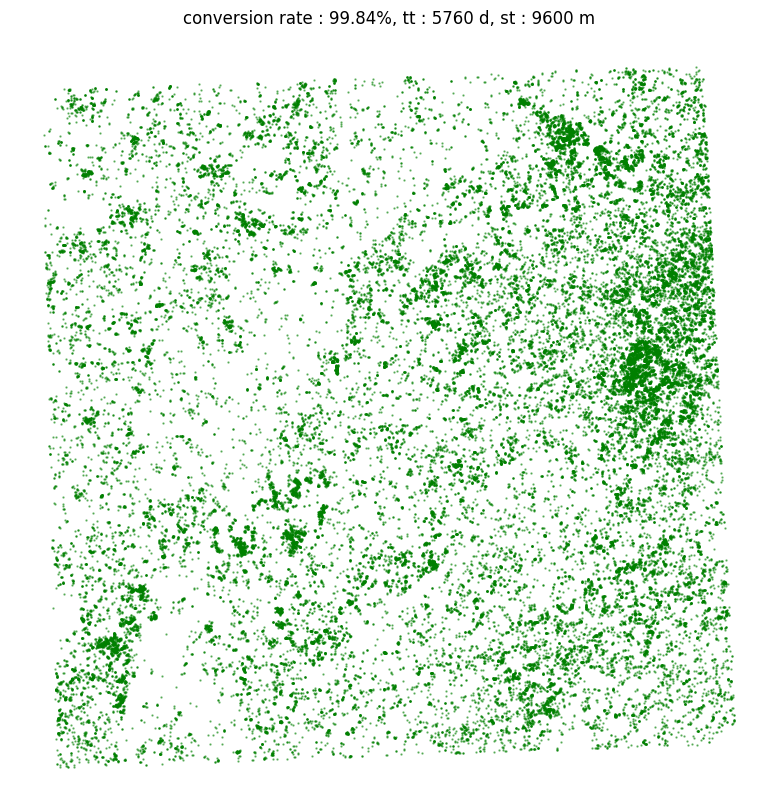

In [4]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(10,10))

#get isolated points : index present in _dataset but not in all_clusters_gdf index
isolated_points = _dataset.drop(index=[i for i in all_clusters_gdf.index if i not in spatial_entity_dataset])
isolated_points_plot = isolated_points.copy()
isolated_points_plot.geometry = isolated_points_plot.geometry.centroid
all_clusters_gdf_plot = all_clusters_gdf.copy()
all_clusters_gdf_plot.geometry = all_clusters_gdf_plot.geometry.centroid

all_clusters_gdf_plot.plot(ax=ax, markersize=0.5, alpha=0.5, color='green')
isolated_points_plot.plot(ax=ax, markersize=0.5, alpha=0.25, color='red')
ax.set_axis_off()
ax.set_title(f'conversion rate : {c :.2%}, tt : {temporal_threshold} d, st : {spatial_threshold} m')

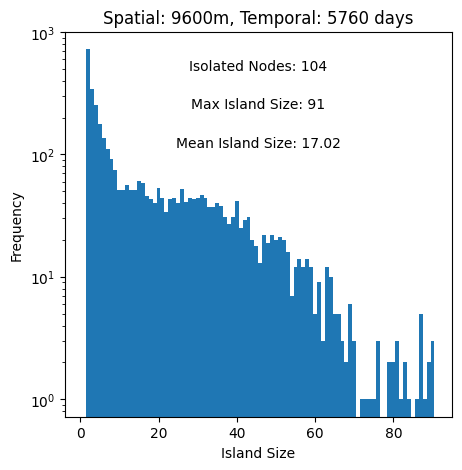

In [5]:
island_sizes = all_clusters_gdf.cluster.value_counts().tolist()
isolated_nodes = _spatial_entity_dataset.shape[0] + _dataset.shape[0] - all_clusters_gdf.shape[0]
import matplotlib.pyplot as plt 
import numpy as np 

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.hist(island_sizes, bins=range(1, max(island_sizes) + 1), align='left', log=True)
ax.set_title(f"Spatial: {spatial_threshold}m, Temporal: {temporal_threshold} days")
ax.set_xlabel('Island Size')
ax.set_ylabel('Frequency')
ax.annotate(f'Isolated Nodes: {isolated_nodes}', xy=(0.5, 0.9), xycoords='axes fraction', ha='center')
ax.annotate(f'Max Island Size: {max(island_sizes)}', xy=(0.5, 0.8), xycoords='axes fraction', ha='center')
ax.annotate(f'Mean Island Size: {np.mean(island_sizes):.2f}', xy=(0.5, 0.7), xycoords='axes fraction', ha='center')
fig.savefig(f'../data/results/clusters/islands_g{attribution.granularity}_{spatial_threshold}m_{temporal_threshold}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.png', dpi=200)

# Similarity weighting

In [11]:
groups = all_clusters_gdf.groupby('cluster')
from itertools import islice 

gr = []
for name, group in islice(groups, 0, 1000):
    gr.append(group)

In [10]:

from utils import compute_tree_coherence, compute_class_similarity, compute_similarity_matrix
from constants import DCLASS_SCORE
dcustom_similarity_function = {'tree specie relatedness': (compute_tree_coherence, {}, 1.0), 'class relatedness': (compute_class_similarity, {'dclass_score': DCLASS_SCORE}, 1.0)}

index = 10
avg_matrix, matrices = compute_similarity_matrix(gr[index], attribution.dtypes_, dcustom_similarity_function, attribution.final_weighting_dict)
gr[index].head(5)

id start_date   end_date  class    dataset  tree_type essence  \
303212  1693297 2017-01-01 2017-12-31  Other  senfseidl  Broadleaf   beech   
303213  1693298 2017-01-01 2017-12-31  Other  senfseidl  Broadleaf   beech   

                                                 geometry centroid_date  \
303212  POLYGON ((976169.346 6685782.265, 976172.039 6...    2017-07-02   
303213  POLYGON ((976139.514 6685779.528, 976109.683 6...    2017-07-02   

        cluster  
303212       10  
303213       10

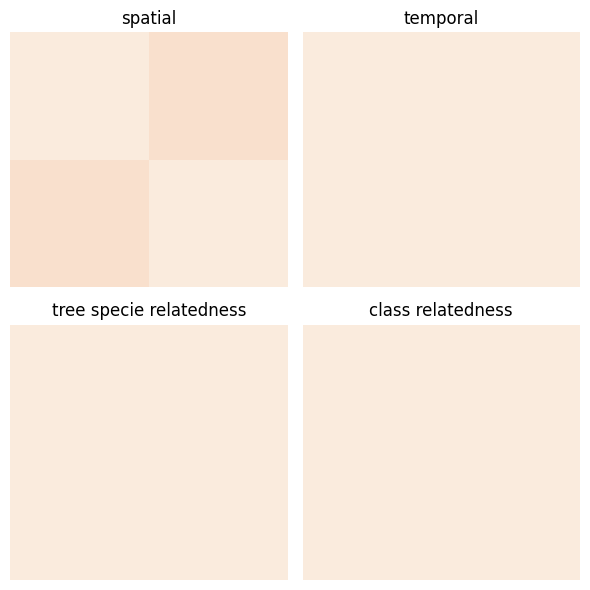

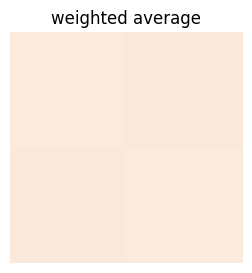

In [11]:
import seaborn as sns
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

for ax, (name, matrix) in zip(axes.ravel(), matrices.items()):
    sns.heatmap(matrix, ax=ax, vmin=0, vmax=1, cbar=False)
    ax.set_title(name)
    ax.set_axis_off()

plt.tight_layout()

weights = (1, 1, 1, 1)
avg = np.average(np.array(list(matrices.values())), axis=0, weights=weights)
fig, ax = plt.subplots(1, 1, figsize=(3,3))
sns.heatmap(avg, ax=ax, vmin=0, vmax=1, cbar=False)
ax.set_title('weighted average')
ax.set_axis_off()

In [9]:
import warnings
from joblib import Parallel, delayed 

from utils import compute_tree_coherence, compute_class_similarity, compute_similarity_matrix
from constants import DCLASS_SCORE
dcustom_similarity_function = {'tree specie relatedness': (compute_tree_coherence, {}, 1.0), 'class relatedness': (compute_class_similarity, {'dclass_score': DCLASS_SCORE}, 1.0)}

with warnings.catch_warnings():
    rr = []
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    for i in tqdm(range(0, len(groups), 1000)):
        r = Parallel(n_jobs=-1, prefer='processes', verbose=0)(delayed(compute_similarity_matrix)(data, attribution.dtypes_, dcustom_similarity_function, attribution.final_weighting_dict) for _,data in islice(groups, i, min(len(groups), i+1000)))
        rr.extend(r)


100%|██████████| 4/4 [11:57<00:00, 179.49s/it]


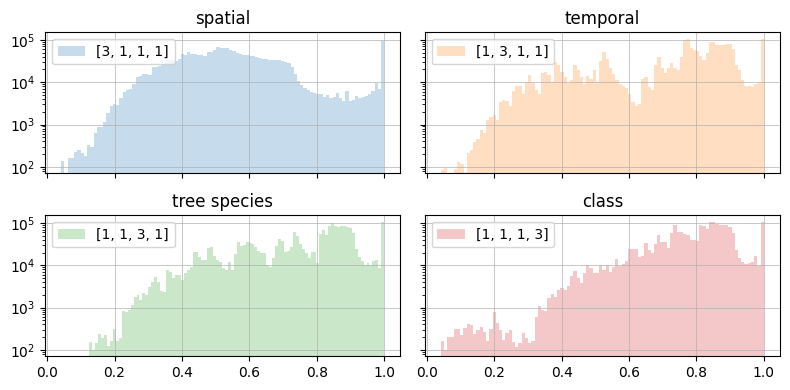

In [15]:
import warnings
from joblib import Parallel, delayed 

def compute_avg_matrix(matrices, weights):
    return np.average(np.array(list(matrices.values())), axis=0, weights=weights)

names = ['spatial', 'temporal', 'tree species', 'class']
fig, axes = plt.subplots(2, 2, figsize=(8, 4), sharex=True, sharey=True)
for i,ax in enumerate(axes.ravel()):
    weights = [1, 1, 1, 1]
    weights[i] = 2
    avg = Parallel(n_jobs=-1, prefer='threads', verbose=0)(delayed(compute_avg_matrix)(r[1], weights) for r in rr)
    avg = [item for matrix in avg for item in matrix.flatten()]
    _ = ax.hist(avg, bins=100, label=str(weights), color=f'C{i}', alpha=0.25, log=True)
    ax.legend()
    ax.grid(lw=0.5)
    ax.set_title(names[i])

plt.tight_layout()


In [25]:
#PCA
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Flatten each matrix and combine them
spatial = []
temporal = []
tree_species = []
class_relatedness = []
for _, matrices in rr:
    spatial.extend(matrices['spatial'].flatten().tolist())
    temporal.extend(matrices['temporal'].flatten().tolist())
    tree_species.extend(matrices['tree specie relatedness'].flatten().tolist())
    class_relatedness.extend(matrices['class relatedness'].flatten().tolist())

# Transpose the data to get the correct shape (features as columns)
data = np.array([spatial, temporal, tree_species, class_relatedness]).T

# Standardize the data
scaler = StandardScaler()
data_std = scaler.fit_transform(data)

# Apply PCA
pca = PCA(n_components=4)  # Assuming you want to keep all four components
pca_result = pca.fit_transform(data_std)

# Analyze the PCA output
print("Explained variance by component:", pca.explained_variance_ratio_)
print("PCA Components:", pca.components_)


Explained variance by component: [0.40759976 0.23017731 0.20566699 0.15655594]
PCA Components: [[-0.55861722 -0.50632909 -0.50877288 -0.41560535]
 [ 0.40901187  0.45822715 -0.31354927 -0.72417126]
 [ 0.23829979 -0.52673279  0.65738302 -0.48333565]
 [ 0.68107951 -0.50617319 -0.4590039   0.26312511]]


NameError: name 'rr' is not defined

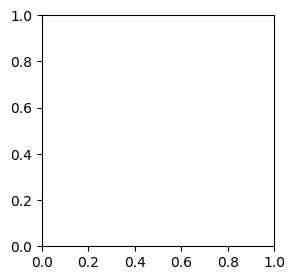

In [51]:
import warnings
from joblib import Parallel, delayed 

def compute_avg_matrix(matrices, weights):
    return np.average(np.array(list(matrices.values())), axis=0, weights=weights)

names = ['spatial', 'temporal', 'tree species', 'class']
fig, ax = plt.subplots(1, 1, figsize=(3, 3), sharex=True, sharey=True)

weights = [0.40759976, 0.23017731, 0.20566699, 0.15655594]
avg = Parallel(n_jobs=-1, prefer='threads', verbose=0)(delayed(compute_avg_matrix)(r[1], weights) for r in rr)
avg = 1 - np.array([item for matrix in avg for item in matrix.flatten()])
_ = ax.hist(avg, bins=100, color=f'C{i}', alpha=0.25, log=True)
ax.legend()
ax.grid(lw=0.5)
ax.set_title(",".join([f"{w :.2f}" for w in weights]))

plt.tight_layout()

We can set 0.23 as eps in DBSCAN

In [63]:
#Elbow/knee method
index = 11
weights = [0.40759976, 0.23017731, 0.20566699, 0.15655594]
similarity_matrix, _ = compute_similarity_matrix(gr[index], attribution.dtypes_, dcustom_similarity_function, attribution.final_weighting_dict, weights) 

<Axes: >

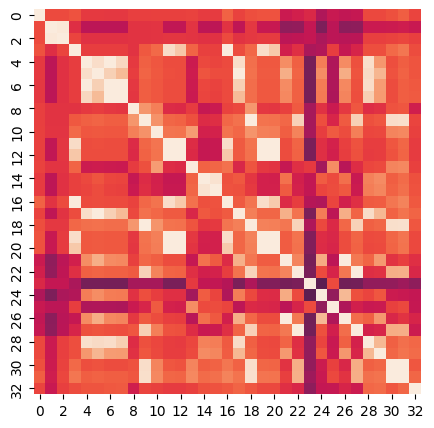

In [64]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.heatmap(similarity_matrix, ax=ax, vmin=0, vmax=1, cbar=False)

(knee) eps = 0.0
(quantile 95) eps = 0.5891552215090948


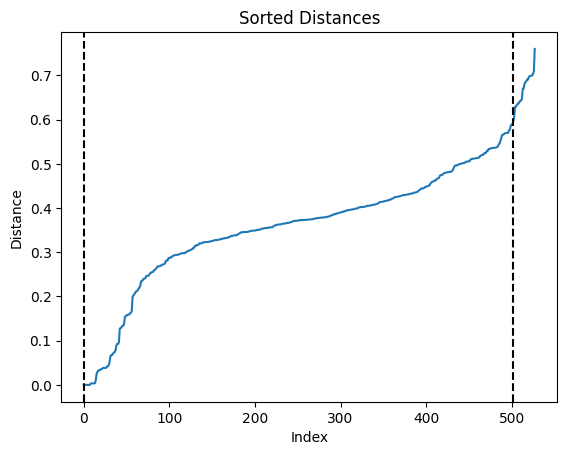

In [68]:
# Convert similarity to distance if necessary (e.g., distance = 1 - similarity)
distance_matrix = 1 - similarity_matrix

# Flatten the distance matrix and sort it
sorted_distances = np.sort(distance_matrix[np.triu_indices_from(distance_matrix, k=1)])

# Plot to find the knee/elbow (optional, for visual inspection)
plt.plot(sorted_distances)
plt.title('Sorted Distances')
plt.xlabel('Index')
plt.ylabel('Distance')


# Automated knee/elbow finding (using a method such as the 'knee' package)
from kneed import KneeLocator
knee_locator = KneeLocator(range(len(sorted_distances)), sorted_distances, curve='concave', direction='increasing')
eps_value = sorted_distances[knee_locator.knee]
print(f'(knee) eps = {eps_value}')
plt.axvline(knee_locator.knee, c='k', ls='--', label=f'knee = {knee_locator.knee}')

# If you're using a quantile-based approach
quantile_value = 0.95  # for example, the 95th percentile
eps_value = np.quantile(sorted_distances, quantile_value)
print(f'(quantile 95) eps = {eps_value}')
plt.axvline(quantile_value * len(sorted_distances), c='k', ls='--', label=f'{quantile_value} quantile')
plt.show()


# Clustering inside communities 

In [76]:
from collections import defaultdict
from utils import get_predominant_class, compute_similarity_matrix, calculate_temporal_centroid
from typing import Callable, Dict, Tuple
from sklearn.cluster import SpectralClustering, DBSCAN
import numpy as np
import matplotlib.pyplot as plt

def get_temporal_period(cluster : gpd.GeoDataFrame, final_weighting_dict : Dict[str, dict]) -> (tuple, Tuple[pd.Timestamp, pd.Timestamp], float):

    upper_bound = 2 * 365 + abs(cluster['start_date'].min() - cluster['end_date'].max()).days
    # Determine the overall time range for the cluster
    start_date = cluster['start_date'].min() - pd.Timedelta(days=upper_bound)
    end_date = cluster['end_date'].max() + pd.Timedelta(days=upper_bound)
    time_range = pd.date_range(start=start_date, end=end_date, freq='2W')

    # Initialize an array to hold the sum of profiles
    sum_profiles = np.zeros(len(time_range))

    for event in cluster.itertuples():
        temporal_profile = final_weighting_dict[event.dataset][event._4]['temporal']
        centroid_date = calculate_temporal_centroid(event.start_date, event.end_date)

        # Days difference from each point in the time range to the centroid
        days_from_centroid = (time_range - centroid_date).days

        # Evaluate the temporal profile
        evaluated_profile = np.array([temporal_profile(abs(day)) for day in days_from_centroid])

        # Accumulate the sum
        sum_profiles += evaluated_profile

    # Average the profiles
    average_profile = sum_profiles / len(cluster)

    # Plotting
    # Assuming 'average_profile' is your array and 'time_range' is your corresponding time axis

    # Find the index of the maximum value in the average profile (peak)
    peak_index = np.argmax(average_profile)
    confidence_threshold = np.percentile(average_profile, 90)
    # Initialize variables to store the desired x-axis values
    x_val_left = None
    x_val_right = None

    # Search to the left of the peak
    for i in range(peak_index, -1, -1):  # Iterate backwards from the peak
        if average_profile[i] <= confidence_threshold:
            x_val_left = time_range[i]
            break

    # Search to the right of the peak
    for i in range(peak_index, len(average_profile)):
        if average_profile[i] <= confidence_threshold:
            x_val_right = time_range[i]
            break

    return (time_range, average_profile), (x_val_left, x_val_right), confidence_threshold

from scipy.spatial import distance   
from shapely.geometry import Polygon, MultiPolygon

def get_spatial_polygon(cluster : gpd.GeoDataFrame, final_weighting_dict: Dict[str, dict]):
    overall_centroid = cluster.geometry.centroid.unary_union.centroid
    grid_size = 30 # Adjust as needed for resolution
    minx, miny, maxx, maxy = cluster.geometry.total_bounds
    width = maxx - minx
    height = maxy - miny

    # Set half_width to be half of the larger dimension of the bounding box
    half_width = max(width, height) 
    x = np.linspace(overall_centroid.x - half_width, overall_centroid.x + half_width, grid_size)
    y = np.linspace(overall_centroid.y - half_width, overall_centroid.y + half_width, grid_size)
    xx, yy = np.meshgrid(x, y)

    # Initialize a 2D array to hold the sum of profiles
    sum_profiles = np.zeros((grid_size, grid_size))

    # Iterate through each event and accumulate its spatial profile
    for event in cluster.itertuples():
        centroid = event.geometry.centroid.coords[0]
        #plot centroid
        spatial_profile_func = final_weighting_dict[event.dataset][event._4]['spatial']

        # Calculate distances from the centroid to each point on the grid
        distances = distance.cdist([(centroid[0], centroid[1])], np.vstack([xx.ravel(), yy.ravel()]).T).reshape(grid_size, grid_size)

        # Evaluate the spatial profile for these distances
        evaluated_profile = np.array([spatial_profile_func(x) for x in np.ravel(distances)]).reshape(grid_size, grid_size)

        # Accumulate the sum
        sum_profiles += evaluated_profile

    # Average the profiles
    average_profile = sum_profiles / len(cluster)

    threshold = np.percentile(average_profile, 90)

    plt.ioff()
    contour = plt.contour(xx, yy, average_profile, levels=[threshold], colors='k', hold='on')
    plt.close()
    polygons = []
    for path in contour.collections[0].get_paths():
        vertices = path.vertices
        polygon = Polygon(vertices)
        polygons.append(polygon)

    # Combine all polygons into a MultiPolygon
    combined_polygon = MultiPolygon(polygons).simplify(10)

    return (xx, yy, average_profile),combined_polygon, threshold
    

def get_cluster(data : gpd.GeoDataFrame, 
                dcustom_similarity_function : Dict[str, Tuple[Callable, dict, float]],
                dtypes_: Dict[str, str], 
                final_weighting_dict : Dict[str, dict],
                doa : Dict[str, float], 
                dclass_score : Dict[str, Dict[str, Dict[str, float]]], 
                weights=[1,1,1,1], 
                method='DBSCAN') -> Tuple[gpd.GeoDataFrame, Tuple[np.ndarray, np.ndarray]]:
    
    """Get the cluster from a GeoDataFrame

    Args:
        data (gpd.GeoDataFrame): GeoDataFrame containing the data to be compared
        dcustom_similarity_function (Dict[str, Tuple[Callable, dict, float]]): dictionary containing the custom similarity functions, the optional arguments and the weight associated with each function
        dtypes_ (Dict[str, str]): dictionary of dataset types
        doa (Dict[str, float]): dictionary of scaling factors
        threshold (float, optional): threshold for the similarity score. Defaults to 0.5.
    
    Returns:
        cluster (gpd.GeoDataFrame): GeoDataFrame containing the clusters
        similarity_matrix (np.ndarray): similarity matrix
        labels (np.ndarray): labels of the cluster
    """

    #build dclass as a dict of list containing the first attribute of the dict of dclass_sco
    similarity_matrix, _ = compute_similarity_matrix(data, dtypes_=dtypes_, dcustom_similarity_function=dcustom_similarity_function, final_weighting_dict=final_weighting_dict, weights=weights)

    # Perform spectral clustering
    # DBSCAN 
    if method == 'DBSCAN':
        distance_matrix = 1 - similarity_matrix
        dbscan = DBSCAN(eps=0.23, min_samples=1, metric='precomputed')
        labels = dbscan.fit_predict(distance_matrix) #distance matrix
    elif method == 'SpectralClustering':
        spectral = SpectralClustering(affinity='precomputed', assign_labels='cluster_qr', random_state=0, n_clusters=None)
        labels = spectral.fit_predict(similarity_matrix) #similarity matrix 

    # Unique cluster labels
    data['labels'] = labels
    cluster_labels = data['labels']
    unique_labels = np.unique(cluster_labels)

    # Dictionary to hold the sum of scores and the count for each cluster
    cluster_sums = {label: {'sum': 0, 'count': 0, 'class': []} for label in unique_labels}

    # Sum scores and counts for each cluster
    for i, (score, label) in enumerate(zip(similarity_matrix[0], cluster_labels)):
        ws = score * doa[data['dataset'].iloc[i]]
        cluster_sums[label]['sum'] += ws 
        cluster_sums[label]['count'] += 1
        cluster_sums[label]['class'].extend([(c,ws,comp) for c, comp in dclass_score[data['dataset'].iloc[i]][data['class'].iloc[i]].items()])

    # Compute average score for each cluster
    average_scores = {label: (cluster_sums[label]['sum'] / cluster_sums[label]['count']) for label in cluster_sums}

    timeperiod_group = {}
    indexes_group = {}
    threshold_group = {}
    polygons_group = {}
    data_ = data.copy()
    data_['start_date'] = pd.to_datetime(data_['start_date'], format='%Y-%m-%d')
    data_['end_date'] = pd.to_datetime(data_['end_date'], format='%Y-%m-%d')

    #get date of the median start and end date for each cluster
    for group in data_['labels'].unique():
        group_df = data_[data_['labels'] == group]
        _, (start, end), temporal_threshold = get_temporal_period(group_df, final_weighting_dict)
        _, polygon, spatial_threshold = get_spatial_polygon(group_df, final_weighting_dict)
        threshold_group[group] = (temporal_threshold, spatial_threshold)
        polygons_group[group] = polygon
        # min_start = group_df['start_date'].mean()
        # max_end = group_df['end_date'].mean()
        timeperiod_group[group] = (start, end)
        indexes_group[group] = group_df.index.tolist()



    for label in average_scores:
        average_scores[label] = (average_scores[label], get_predominant_class(cluster_sums[label]['class']), timeperiod_group[label], indexes_group[label], threshold_group[label], polygons_group[label])

    # Convert the filtered dictionary into a DataFrame
    df = pd.DataFrame.from_dict(average_scores, orient='index', columns=['IntraSimilarity', 'Class', 'TimePeriod', 'Indexes', 'Threshold', 'geometry'])

    # Ensure the dates are in the correct format (if they are strings)
    df['Start_Date'], df['End_Date'] = zip(*df['TimePeriod'])
    df['Temporal_threshold'], df['Spatial_threshold'] = zip(*df['Threshold'])
    df = df.drop(['TimePeriod', 'Threshold'], axis=1)

    # Convert the string dates to datetime objects if needed
    df['Start_Date'] = pd.to_datetime(df['Start_Date'], dayfirst=True)
    df['End_Date'] = pd.to_datetime(df['End_Date'], dayfirst=True)

    return gpd.GeoDataFrame(df.sort_values(by='IntraSimilarity', ascending=False), geometry='geometry', crs=data.crs), (similarity_matrix, labels)


def wrapper_get_cluster(data: gpd.GeoDataFrame, dtypes_, dcustom_similarity_function, doa, dclass_score, final_weighting_dict, threshold, weights):
    """Wrapper function for get_cluster"""

    if len(data) == 1:
        return pd.DataFrame({'Similarity':[0.], 'Class':['Unknown'], 'Start_Date':[data.iloc[0].start_date], 'End_Date':[data.iloc[0].end_date], 'index_reference':[data.iloc[0].index_reference]}), (np.array(1), [1])
    else:
        return get_cluster(data, dtypes_=dtypes_, dcustom_similarity_function=dcustom_similarity_function, doa=doa, dclass_score=dclass_score, final_weighting_dict=final_weighting_dict, threshold=threshold, weights=weights) 



In [101]:
import warnings
from joblib import Parallel, delayed 
import pandas as pd 
from utils import compute_tree_coherence, compute_class_similarity
from constants import DCLASS_SCORE
import time 

method = 'SpectralClustering'
dcustom_similarity_function = {'tree specie relatedness': (compute_tree_coherence, {}, 1.0), 'class relatedness': (compute_class_similarity, {'dclass_score': DCLASS_SCORE}, 1.0)}
weights = [0.40759976, 0.23017731, 0.20566699, 0.15655594]

start = time.time()
with warnings.catch_warnings():
    list_gdf = []
    list_matrices = []
    list_labels = []
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    for i in tqdm(range(0, len(groups), 1000)):
        r = Parallel(n_jobs=-1, prefer='processes', verbose=0)(delayed(get_cluster)(data=data, dtypes_=attribution.dtypes_, dcustom_similarity_function=dcustom_similarity_function, doa=attribution.doa, dclass_score=DCLASS_SCORE, final_weighting_dict=attribution.final_weighting_dict, weights=weights) for _,data in islice(groups, i, min(len(groups), i+1000)))
        for x in r:
            list_gdf.append(x[0])
            list_matrices.append(x[1][0])
            list_labels.append(x[1][1])
end = time.time()

df = pd.concat(list_gdf)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=attribution.dataset.crs)
gdf.to_parquet(f"../data/results/clusters/clusters_m{method}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.parquet")

from sklearn.metrics import davies_bouldin_score
# Dunn index is not directly available in sklearn but can be implemented or imported from other libraries.

# Example for Davies-Bouldin Score and Calinski-Harabasz Score
davies_bouldin_scores = []

for similarity_matrix, labels in zip(list_matrices, list_labels):
    # Ensure that labels have at least one cluster and less than n_samples clusters
    if 1 < len(set(labels)) < len(labels):
        # Convert similarity matrix to distance matrix if necessary
        distance_matrix = 1 - similarity_matrix
        
        # Calculate the Davies-Bouldin Score
        db_score = davies_bouldin_score(X=distance_matrix, labels=labels)
        davies_bouldin_scores.append(db_score)
        
    else:
        davies_bouldin_scores.append(None)

# Filter out None values
davies_bouldin_scores = [score for score in davies_bouldin_scores if score is not None]

#create a dict with the parameters of the nethod (spatial and temporal threshold, etc) as well as the execution time and mean david bouldin score
cluster_parameters = {'spatial_threshold': spatial_threshold_, 
                      'temporal_threshold': temporal_threshold_, 
                      'method': method, 
                      'weights': weights, 
                      'resolution': resolution,
                    'granularity': attribution.granularity,
                    'version': attribution.version,
                    'bounds': bounds_4326,
                    'n': n,
                    'm': m,
                      'execution_time': end - start, 
                      'davies_bouldin_score': np.mean(davies_bouldin_scores)}

#load the json if already existing and add this new dict to it 
import json
if os.path.isfile(f"../data/results/clusters/cluster_parameters.json"):
    with open(f"../data/results/clusters/cluster_parameters.json", 'r') as f:
        cluster_parameters_dict = json.load(f)
    cluster_parameters_dict.append(cluster_parameters)
#dump the json
with open(f"../data/results/clusters/cluster_parameters.json", 'w') as f:
    json.dump(cluster_parameters_dict, f)



  0%|          | 0/4 [00:00<?, ?it/s]/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_2571/1831670484.py:99: UserWarning: The following kwargs were not used by contour: 'hold'
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_2571/1831670484.py:99: UserWarning: The following kwargs were not used by contour: 'hold'
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_2571/1831670484.py:99: UserWarning: The following kwargs were not used by contour: 'hold'
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_2571/1831670484.py:99: UserWarning: The following kwargs were not used by contour: 'hold'
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_2571/1831670484.py:99: UserWarning: The following kwargs were not used by contour: 'hold'
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_2571/1831670484.py:99: UserWarning: The following kwargs were not used by contour: 'hold'
/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_2571/18316

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

In [106]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
# Dunn index is not directly available in sklearn but can be implemented or imported from other libraries.

# Example for Davies-Bouldin Score and Calinski-Harabasz Score
davies_bouldin_scores = []

for similarity_matrix, labels in zip(list_matrices, list_labels):
    # Ensure that labels have at least one cluster and less than n_samples clusters
    if 1 < len(set(labels)) < len(labels):
        # Convert similarity matrix to distance matrix if necessary
        distance_matrix = 1 - similarity_matrix
        
        # Calculate the Davies-Bouldin Score
        db_score = davies_bouldin_score(X=distance_matrix, labels=labels)
        davies_bouldin_scores.append(db_score)
        
    else:
        davies_bouldin_scores.append(None)

# Filter out None values
davies_bouldin_scores = [score for score in davies_bouldin_scores if score is not None]

#create a dict with the parameters of the nethod (spatial and temporal threshold, etc) as well as the execution time and mean david bouldin score
cluster_parameters = {'spatial_threshold': spatial_threshold_, 
                      'temporal_threshold': temporal_threshold_, 
                      'method': method, 
                      'weights': weights, 
                      'resolution': resolution,
                    'granularity': attribution.granularity,
                    'version': attribution.version,
                    'bounds': bounds_4326,
                    'n': n,
                    'm': m,
                      'execution_time': end - start, 
                      'davies_bouldin_score': np.mean(davies_bouldin_scores)}

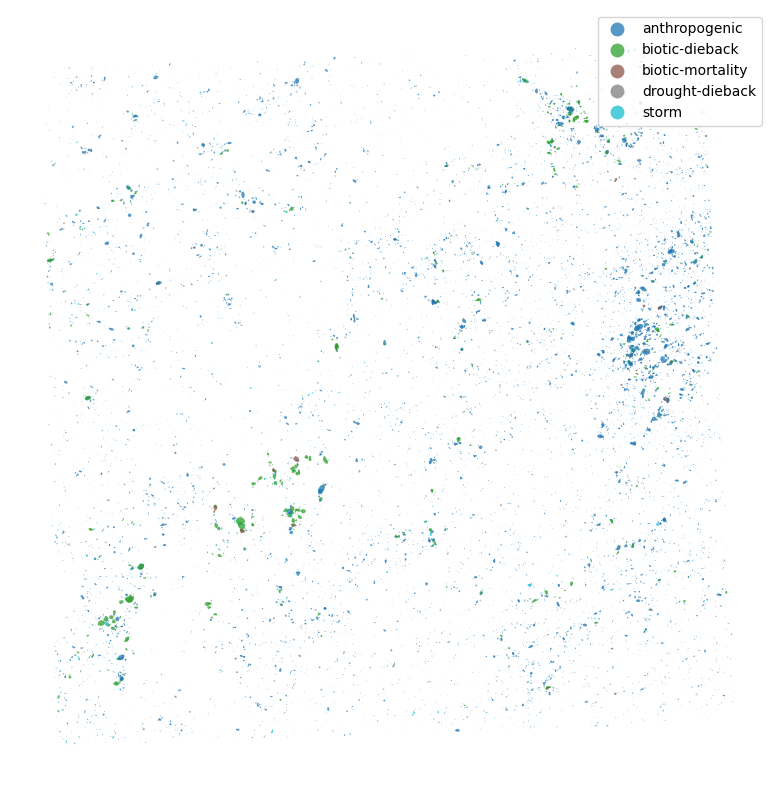

In [108]:
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, column='Class', alpha=0.75, legend=True)
ax.set_axis_off()

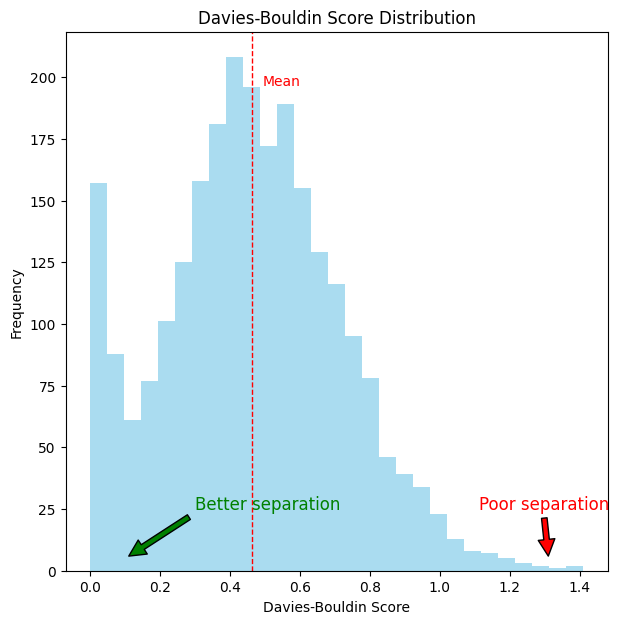

In [107]:
import matplotlib.pyplot as plt

# Filter out None values
davies_bouldin_scores = [score for score in davies_bouldin_scores if score is not None]

# Plot Davies-Bouldin scores
plt.figure(figsize=(7, 7))

# First subplot for Davies-Bouldin Index
plt.subplot(1, 1, 1)
plt.hist(davies_bouldin_scores, bins='auto', color='skyblue', alpha=0.7)
plt.title('Davies-Bouldin Score Distribution')
plt.xlabel('Davies-Bouldin Score')
plt.ylabel('Frequency')
plt.axvline(np.mean(davies_bouldin_scores), color='red', linestyle='dashed', linewidth=1)
plt.text(np.mean(davies_bouldin_scores) + 0.03, max(plt.gca().get_ylim()) * 0.9, 'Mean', color = 'red')

# Annotations for Davies-Bouldin (lower is better)
plt.annotate('Better separation', xy=(0.1, 5), xytext=(0.3, 25),
             arrowprops=dict(facecolor='green', shrink=0.05), fontsize=12, color='green')
plt.annotate('Poor separation', xy=(max(davies_bouldin_scores) - 0.1, 5), xytext=(max(davies_bouldin_scores) - 0.3, 25),
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=12, color='red')

plt.tight_layout
plt.savefig(f'../data/results/clusters/davies_bouldin_scores_m{method}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.png', dpi=200)